In [1]:
#head following, all neural network

#each step (0.1 seconds) input
# n y position neurons  (n)

# last step's servo requests (1)
# servo response (1)
# angle from horizon (1)
# --not yet-- n x position neurons
# --not yet-- delta theta


#each step output
# n y position neurons (n)
# servo response (1)

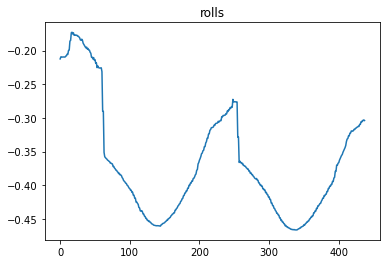

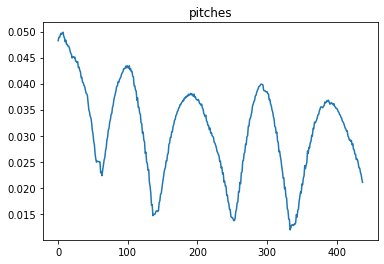

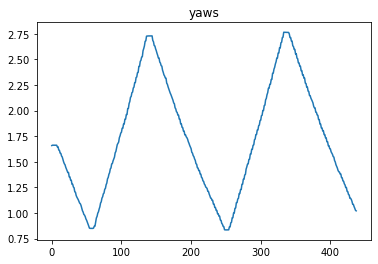

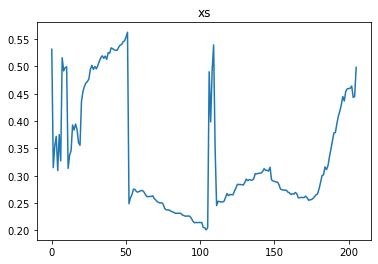

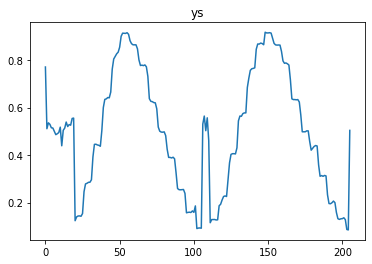

In [2]:
import sys, os
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii","underpinnings")))
from notebook_log_loading import load_sensor_log_file
from id_to_name import id_to_name
sensor_log,first_timestamp=load_sensor_log_file("../to_study/neck_up_and_down.txt")
from matplotlib import pyplot as plt


import math
 
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians
    
rolls=[]
pitches=[]
yaws=[]
xs=[]
ys=[]
    
for message in sensor_log:
    #print(message.keys())
    if "packets" in message:
        x,y,z,w,acc=message["packets"][-1]["rotation_vector"]
        #note I have to switch angle defs here.  yaw is first, not sure about other two
        #with yaw, pi/2 is horizontal
        yaw,roll,pitch=euler_from_quaternion(x,y,w,z)
        rolls.append(roll)
        pitches.append(pitch)
        yaws.append(yaw)
        #print(roll,pitch,yaw)
    if "detections" in message:
        for det in message["detections"]:
            x=0.5*(det["bbox_array"][0]+det["bbox_array"][1])
            y=0.5*(det["bbox_array"][2]+det["bbox_array"][3])
            xs.append(x)
            ys.append(y)

        
plt.title("rolls")
plt.plot(rolls)
plt.show()

plt.title("pitches")
plt.plot(pitches)
plt.show()

plt.title("yaws")
plt.plot(yaws)
plt.show()

plt.title("xs")
plt.plot(xs)
plt.show()

plt.title("ys")
plt.plot(ys)
plt.show()

In [3]:
#take messages as input, store neuron info, report an reset as needed
from NNCalibration3 import MessagesToNNState
from NNCalibration3 import DatasetBuilder
from collections import deque

class ActionChoiceContinuous:
    def __init__(self,predictor,policy):
        self.state_history_length=10
        self.predictor=predictor
        #predictor takes a number of previous states and makes a prediction about the next n states
        self.policy=policy
        self.recent_state_history=deque([],self.state_history_length)
        
    def observe(self,new_state):
        self.recent_state_history.append(new_state)
        
    def choose_action(self):
        ...
        
#So there eare two options here
# discrete action choice
#   can potentially explore every future possibility or use vterbi search
#   for faster, could train based on above
#   For small timespans, no need to use deep Q anything

# continuous action choice
#   cannot explore everything
#   can train based on Q derivite
class ActionChoiceDiscrete:
    def __init__(self,predictor):
        self.state_history_length=10
        self.predictor=predictor
        self.policy=policy
        self.recent_state_history=deque([],self.state_history_length)

class ActorAndTrainer:
    def __init__(self):
        ...
        
    def read_message(self,m):
        ...
        #immediate part
        #Reb 


In [4]:
#turn message log into training set
    
    
datasetbuilder=DatasetBuilder()

for message in sensor_log:
    datasetbuilder.read_message(message)
    
dataset=datasetbuilder.obtain_dataset_and_reset()

#(state,command,output)=dataset[0]
state,input_control,output_control,output=dataset[0]
#print(a)
#state,command,output=dataset[0]
print(state.shape)
print(input_control.shape)
print(output.shape)


{'timestamp': 1635830599.2742965, 'motor_response': {'left_throttle': 0, 'right_throttle': 0, 'left_duration': 0, 'right_duration': 0}, 'keys': ['motor_response']}
torch.Size([10, 10])
torch.Size([10, 2])
torch.Size([2, 4])


In [5]:
import torch.nn as nn

class PredictorModel(nn.Module):
    #The presumption is that this module is provided with
    # input + control vectors for N steps
    # and then for the next M steps, it is provided control vectors, and must predict the output vectors
    def __init__(self,input_size,control_size,output_size):
        #super(PredictorModel, self).__init__()
        super().__init__()
        hidden_size=input_size+control_size
        self.encoder_lstm=nn.LSTM(input_size+control_size,
                               hidden_size=hidden_size,
                               num_layers=1,
                               batch_first=True)
        self.decoder_lstm=nn.LSTM(control_size,
                               hidden_size=hidden_size,
                               num_layers=1,
                               batch_first=True)
        self.decoder_interpreter=nn.Sequential(nn.Linear(hidden_size,output_size),
                                               nn.Sigmoid())

    def predict_from_hc(self,hc,output_control_vectors):
        encoded_outputs,output_hc=self.decoder_lstm(output_control_vectors,hc)
        results=self.decoder_interpreter(encoded_outputs)
        return results,output_hc
        
    def forward(self,input_vectors,input_control_vectors,output_control_vectors):
        #print("input shape {}".format(input_vectors.shape))
        #print("input control shape {}".format(input_control_vectors.shape))
        #print("output control shape {}".format(output_control_vectors.shape))        
        #encode
        total_input_vectors=torch.cat((input_vectors,input_control_vectors),2)
        encoded_inputs,(hencoding,cencoding)=self.encoder_lstm(total_input_vectors)
        #print("hencoding shape {}".format(hencoding.shape))
        #decode
        #encoded_outputs,output_hc=self.decoder_lstm(output_control_vectors,(hencoding,cencoding))        
        #results=self.decoder_interpreter(encoded_outputs)
        #return results,output_hc
        return self.predict_from_hc((hencoding,cencoding),output_control_vectors)

print(state.shape)
print(input_control.shape)
print(output.shape)


predictormodel=PredictorModel(state.shape[1],input_control.shape[1],output.shape[1])

torch.Size([10, 10])
torch.Size([10, 2])
torch.Size([2, 4])


In [7]:
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

def train(mymodel,dataset):
    loader=DataLoader(dataset,batch_size=64,shuffle=True)
    loss_function = torch.nn.MSELoss()
    optimizer = optim.Adam(mymodel.parameters(), lr=0.01)
    train_epochs=1000
    losses=[]
    for epoch in tqdm(range(train_epochs)):
        for inputs,control_inputs,control_outputs,outputs in loader:
            yprime,_=mymodel(inputs,control_inputs,control_outputs)         
            loss=loss_function(yprime,outputs )
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
    return losses

the_losses=train(predictormodel,dataset)

  2%|█▋                                                                              | 21/1000 [00:02<02:07,  7.69it/s]


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
plt.title("Loss")
ax.plot(np.log(the_losses))
plt.show()

In [ ]:
def show_examples(mymodel,dataset):
    loader=DataLoader(dataset,batch_size=64,shuffle=True)
    counter=0
    for inputs,control_inputs,control_outputs,outputs in loader:
        yprime,_=mymodel(inputs,control_inputs,control_outputs)
        #print(inputs.shape)
        #print(outputs.shape)
        #print(yprime.shape)
        #print(datasetbuilder.output_placement_map)
        for key in datasetbuilder.output_placement_map:
            print("key {}".format(key))
            if key in datasetbuilder.state_placement_map:
                oi=datasetbuilder.output_placement_map[key]
                ii=datasetbuilder.state_placement_map[key]
                #print("oi {} ii {}".format(oi,ii))
                truth=torch.cat([inputs[:,:,ii],outputs[:,:,oi]],dim=1)
                guess=torch.cat([inputs[:,:,ii],yprime.detach()[:,:,oi]],dim=1)
                #print(key)
                plt.title(key)
                plt.plot(truth[0,:],label="truth")
                plt.plot(guess[0,:],label="guess")
                plt.legend()
                plt.show()
            else:
                oi=datasetbuilder.output_placement_map[key]
                plt.title(key)
                plt.plot(outputs[0,:,oi],label='truth')
                plt.plot(yprime.detach()[0,:,oi],label='guess')
                plt.legend()
                plt.show()

        
        #all_states=torch.cat([inputs[:,:,0:outputs.shape[2]],outputs[:,:,:]],dim=1)
        #my_guess=torch.cat([inputs[:,:,0:outputs.shape[2]],yprime.detach()],dim=1)
        #all_control=torch.cat([control_inputs,control_outputs],dim=1)
        #print(inputs.shape)
        #print("example {}".format(counter))
        #plt.plot(all_states[0,:,0])
        #plt.plot(my_guess[0,:,0])
        #plt.plot(all_control[0,:,0])
        #plt.show()
        
        #plt.plot(all_states[0,:,1])
        #plt.plot(my_guess[0,:,1])
        #plt.plot(all_control[0,:,0])
        #plt.show()

        counter+=1
        if counter>10:
            break
            
show_examples(predictormodel,dataset)

In [ ]:
def extract_q_value(states):
    ...